# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://iie.fing.edu.uy/~jlezama/DLVIS2020/entregables.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time
np.random.seed(1)
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.381722
sanity check: 2.302585


**Inline Question 1**

- 1.1 Why do we expect our loss to be close to -log(0.1)? Explain briefly.
- 1.2 What are the minimum and maximum possible value for the Softmax loss? 

$\color{blue}{\textit Your Answer:}$ 

- 1.1 Notar que $W$ es inicializada de forma aleatoria, esto lleva a que la etiqueta que se le asigne a cada imagen sera aleatoria, teniendo aproximadamente las mismas posibilidades todas las clases. Como tenemos 10 clases, la probabilidad que se le asignara a cada muestra sera cercana a $0.1$, entonces por la formula de la perdida de softmax se tiene que la loss sera cercana a $-log(0.1)$.

- 1.2 El valor mínimo es $0$, esto se da cuando a todas las muestras se le asigna correctamente la etiqueta con probabilidad $1$. El valor máximo no esta acotado, si se asignara probabilidades cercanas a 0 a la clase correcta se tendrá una loss muy grande.



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.892150 analytic: 3.892150, relative error: 1.421129e-08
numerical: 0.411780 analytic: 0.411780, relative error: 4.036655e-08
numerical: 0.999081 analytic: 0.999081, relative error: 3.803141e-08
numerical: -0.126808 analytic: -0.126808, relative error: 1.692235e-07
numerical: 0.086709 analytic: 0.086709, relative error: 9.615608e-07
numerical: 0.107266 analytic: 0.107266, relative error: 2.887380e-07
numerical: -4.571797 analytic: -4.571798, relative error: 1.366390e-08
numerical: 1.530631 analytic: 1.530631, relative error: 4.588050e-08
numerical: 0.225588 analytic: 0.225588, relative error: 2.885537e-08
numerical: 0.477503 analytic: 0.477503, relative error: 8.977367e-08
numerical: 3.602283 analytic: 3.602283, relative error: 1.667189e-08
numerical: -0.001558 analytic: -0.001558, relative error: 4.505969e-06
numerical: -3.592238 analytic: -3.592238, relative error: 6.991732e-09
numerical: 0.794997 analytic: 0.794997, relative error: 7.181040e-08
numerical: -1.622692 analy

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# W e use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.381722e+00 computed in 0.149719s
vectorized loss: 2.381722e+00 computed in 0.007956s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [8]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1527.915531
iteration 100 / 1500: loss 561.196190
iteration 200 / 1500: loss 207.057396
iteration 300 / 1500: loss 77.304647
iteration 400 / 1500: loss 29.778058
iteration 500 / 1500: loss 12.308736
iteration 600 / 1500: loss 5.957554
iteration 700 / 1500: loss 3.604799
iteration 800 / 1500: loss 2.759612
iteration 900 / 1500: loss 2.458631
iteration 1000 / 1500: loss 2.322248
iteration 1100 / 1500: loss 2.300956
iteration 1200 / 1500: loss 2.259872
iteration 1300 / 1500: loss 2.262543
iteration 1400 / 1500: loss 2.279561
That took 6.518253s


In [7]:
%qtconsole

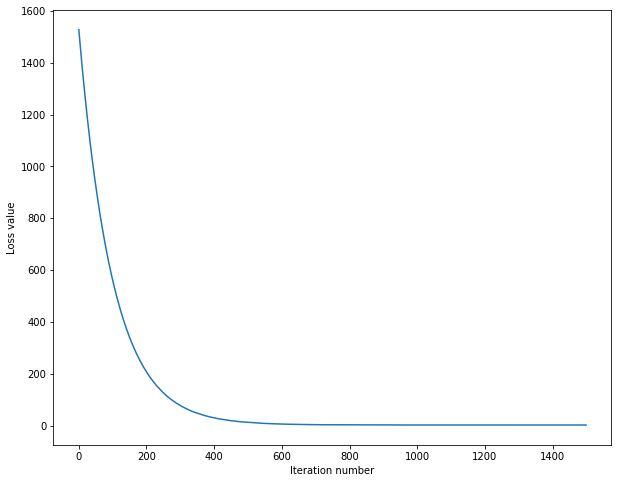

In [9]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.303857
validation accuracy: 0.319000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save  the best trained softmax classifer in best_softmax.                    #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-2]
regularization_strengths = [1e4, 1e3, 1e2, 1e1, 1e-1, 1-2]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
acc = list()
best_val = -1
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val>best_val:
            best_softmax =  softmax
            best_val = acc_val
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/home/camilo/Maestria/DLVis/DLVIS_2020/ob1/cs231n/classifiers/softmax.py:98: RuntimeWarning: divide by zero encountered in log
  salidas = -np.log(numerador/denominador)
/home/camilo/Maestria/DLVis/DLVIS_2020/ob1/cs231n/classifiers/softmax.py:92: RuntimeWarning: overflow encountered in exp
  exp_XW = np.exp(XW/T)
/home/camilo/Maestria/DLVis/DLVIS_2020/ob1/cs231n/classifiers/softmax.py:98: RuntimeWarning: invalid value encountered in true_divide
  salidas = -np.log(numerador/denominador)
/home/camilo/Maestria/DLVis/DLVIS_2020/ob1/cs231n/classifiers/softmax.py:106: RuntimeWarning: invalid value encountered in true_divide
  dW += X.T @ (numeradores/denominador.reshape((-1,1)))


lr 1.000000e-07 reg -1.000000e+00 train accuracy: 0.240714 val accuracy: 0.227000
lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.253184 val accuracy: 0.250000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.245857 val accuracy: 0.239000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.244735 val accuracy: 0.247000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.256857 val accuracy: 0.281000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.353122 val accuracy: 0.370000
lr 1.000000e-06 reg -1.000000e+00 train accuracy: 0.347408 val accuracy: 0.359000
lr 1.000000e-06 reg 1.000000e-01 train accuracy: 0.346449 val accuracy: 0.325000
lr 1.000000e-06 reg 1.000000e+01 train accuracy: 0.343143 val accuracy: 0.344000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.369327 val accuracy: 0.381000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.400408 val accuracy: 0.404000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.345755 val accuracy: 0.357000
lr 1.000000e-05 reg -1.000

**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution: 
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?
- How would it affect the training process? You may test this experimentally.


$\color{blue}{\textit Your Answer:}$

1. Valores de $T<1$ generan **mayor** seguridad. A menor valor la clase con más score se le asigna una probabilidad más alta.
2. Valores de $T>1$ generan **mayor** seguridad. A mayor valor, todas las clases son mas equiprobables.

Es decir, el valor de T se encarga de suavizar o no la distribución de probabilidad de salida.

Un valor de T elevado hace que durante el entrenamiento los gradientes se propaguen hacia atras con más fuerza ya que se esta más lejos de la solución optima, mientras que valores bajos generan que el gradiente se propague menos. Una forma de determinar el T optimo puede ser mediante validación cruzada.

Se modifico el código de las partes anteriores y se prueba experimentalmente cual es el T optimo mediante validacion cruzada con el resto de parámetros fijos. En el grafico de las loss se observa que con valores de T pequeños se generan scores altos y por lo tanto un entrenamiento ruidoso. El valor de T obtenido con validación cruzada es 1.

El valor de T es 0.3
training accuracy: 0.294796
validation accuracy: 0.298000
--------------------------------------------------
El valor de T es 0.5666666666666667
training accuracy: 0.396816
validation accuracy: 0.386000
--------------------------------------------------
El valor de T es 0.8333333333333335
training accuracy: 0.399306
validation accuracy: 0.393000
--------------------------------------------------
El valor de T es 1.1
training accuracy: 0.397551
validation accuracy: 0.403000
--------------------------------------------------
El valor de T es 1.366666666666667
training accuracy: 0.394347
validation accuracy: 0.395000
--------------------------------------------------
El valor de T es 1.6333333333333335
training accuracy: 0.386612
validation accuracy: 0.401000
--------------------------------------------------
El valor de T es 1.9000000000000004
training accuracy: 0.382143
validation accuracy: 0.387000
--------------------------------------------------
El valor de T es

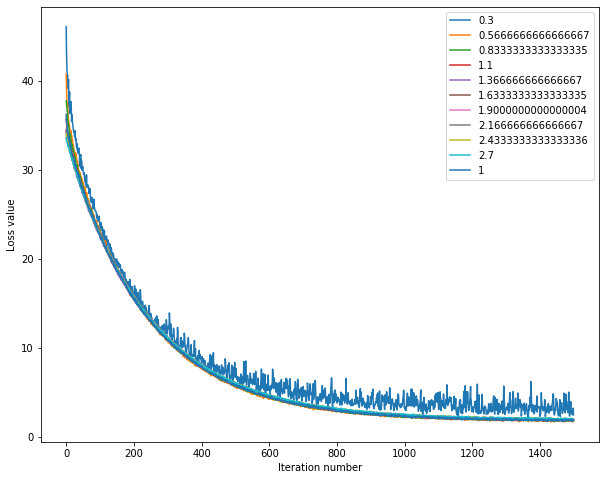

In [58]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
plt.figure()
best_val = -1
for T in list(np.linspace(0.3,2.7,10))+[1]:
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=1e-6, reg=1e3,
                          num_iters=1500, verbose=False, T=T)
    plt.plot(loss_hist, label=f'{T}')
    y_train_pred = softmax.predict(X_train)
    print(f'El valor de T es {T}')
    print( f'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
    y_val_pred = softmax.predict(X_val)
    print( f'validation accuracy: %f' % (acc_val:=np.mean(y_val == y_val_pred), ))
    print('-'*50)
    if acc_val>best_val:
            best_softmax =  softmax
            best_val = acc_val
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()


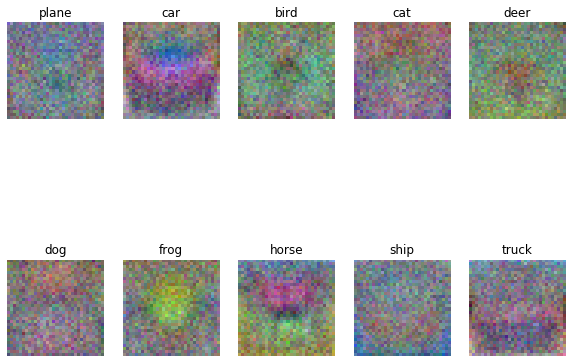

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])